In [5]:
# Imports needed across sections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate
from IPython.display import display, HTML

In [41]:
month_gas = pd.read_csv("monthly_gasoline_makeup_percentages.csv")
month_transport = pd.read_csv("monthly_transportation_statistics.csv")
stock = pd.read_csv("all_stocks_and_etfs.csv")
week_gas = pd.read_csv("weekly_gasoline_prices.csv")
week_supply = pd.read_csv("weekly_supply_estimates.csv")

In [19]:
print("The shape of the gas data is ", month_gas.shape)
print("Gas Data Info:")
print(month_gas.info())
print("\nFirst few rows of Gas Data:")
print(month_gas.head())

print("\nSummary Statistics for Gas Data:")
print(month_gas.describe())

The shape of the gas data is  (548, 10)
Gas Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date_String                 548 non-null    object 
 1   Date                        548 non-null    object 
 2   Retail_Price                548 non-null    float64
 3   Refining                    548 non-null    float64
 4   Distribution_and_Marketing  548 non-null    float64
 5   Taxes                       548 non-null    float64
 6   Crude_Oil                   548 non-null    float64
 7   Type                        548 non-null    object 
 8   Year                        548 non-null    int64  
 9   Month                       548 non-null    int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 42.9+ KB
None

First few rows of Gas Data:
  Date_String       Date  Retail_Price  Refining  Distribut

In [27]:
# More visually appealing heads of the data

month_gas_html = tabulate(month_gas.head(), headers='keys', tablefmt='html')
month_transport_html = tabulate(month_transport.head(), headers='keys', tablefmt='html')
stock_html = tabulate(stock.head(), headers='keys', tablefmt='html')
week_gas_html = tabulate(week_gas.head(), headers='keys', tablefmt='html')
week_supply_html = tabulate(week_supply.head(), headers='keys', tablefmt='html')

month_gas_table_html = f'<h3>month_gas</h3>{month_gas_html}'
month_transport_table_html = f'<h3>month_transport</h3>{month_transport_html}'
stock_table_html = f'<h3>stock</h3>{stock_html}'
week_gas_table_html = f'<h3>week_gas</h3>{week_gas_html}'
week_supply_table_html = f'<h3>week_supply</h3>{week_supply_html}'

display(HTML(month_gas_table_html))
display(HTML(month_transport_table_html))
display(HTML(stock_table_html))
display(HTML(week_gas_table_html))
display(HTML(week_supply_table_html))

,Date_String,Date,Retail_Price,Refining,Distribution_and_Marketing,Taxes,Crude_Oil,Type,Year,Month
0,Dec-23,12/1/2023,3.134,8.3,19.4,16.2,56.2,Regular,2023,12
1,Nov-23,11/1/2023,3.318,8.1,19.6,15.3,57,Regular,2023,11
2,Oct-23,10/1/2023,3.613,7.3,21.5,14,57.2,Regular,2023,10
3,Sep-23,9/1/2023,3.836,19.4,12.3,13.2,55,Regular,2023,9
4,Aug-23,8/1/2023,3.84,25.3,11.3,13.2,50.2,Regular,2023,8


,Date,Month,Year,Air Safety - General Aviation Fatalities,Highway Fatalities Per 100 Million Vehicle Miles Traveled,Highway Fatalities,U.S. Airline Traffic - Total - Seasonally Adjusted,U.S. Airline Traffic - International - Seasonally Adjusted,U.S. Airline Traffic - Domestic - Seasonally Adjusted,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,Transit Ridership - Urban Rail - Adjusted,Freight Rail Intermodal Units,Freight Rail Carloads,Highway Vehicle Miles Traveled - All Systems,Highway Vehicle Miles Traveled - Total Rural,Highway Vehicle Miles Traveled - Other Rural,Highway Vehicle Miles Traveled - Rural Other Arterial,Highway Vehicle Miles Traveled - Rural Interstate,State and Local Government Construction Spending - Breakwater/Jetty,State and Local Government Construction Spending - Dam/Levee,State and Local Government Construction Spending - Conservation and Development,State and Local Government Construction Spending - Pump Station,State and Local Government Construction Spending - Line,State and Local Government Construction Spending - Water Treatment Plant,State and Local Government Construction Spending - Water Supply,State and Local Government Construction Spending - Line/Drain,State and Local Government Construction Spending - Waste Water Treatment Plant,State and Local Government Construction Spending - Waste Water,State and Local Government Construction Spending - Line/Pump Station,State and Local Government Construction Spending - Sewage Treatment Plant,State and Local Government Construction Spending - Sewage / Dry Waste,State and Local Government Construction Spending - Sewage and Waste Disposal,State and Local Government Construction Spending - Rest Facility,State and Local Government Construction Spending - Bridge,State and Local Government Construction Spending - Lighting,State and Local Government Construction Spending - Pavement,State and Local Government Construction Spending - Highway and Street,State and Local Government Construction Spending - Power,State and Local Government Construction Spending - Dock / Marina,State and Local Government Construction Spending - Water,State and Local Government Construction Spending - Mass Transit,State and Local Government Construction Spending - Land Passenger Terminal,State and Local Government Construction Spending - Land,State and Local Government Construction Spending - Runway,State and Local Government Construction Spending - Air Passenger Terminal,State and Local Government Construction Spending - Air,State and Local Government Construction Spending - Transportation,State and Local Government Construction Spending - Park / Camp,State and Local Government Construction Spending - Neighborhood Center,State and Local Government Construction Spending - Social Center,State and Local Government Construction Spending - Convention Center,State and Local Government Construction Spending - Performance / Meeting Center,State and Local Government Construction Spending - Sports,State and Local Government Construction Spending - Amusement and Recreation,State and Local Government Construction Spending - Fire & Rescue,State and Local Government Construction Spending - Other Public Safety,State and Local Government Construction Spending - Police & Sheriff,State and Local Government Construction Spending - Detention,State and Local Government Construction Spending - Correctional,State and Local Government Construction Spending - Public Safety,State and Local Government Construction Spending - Library / Archive,State and Local Government Construction Spending - Other Educational,State and Local Government Construction Spending - Infrastructure,State and Local Government Construction Spending - Sports & Recreation,State and Local Government Construction Spending - Dormitory,State and Local Government Construction Spending - Instructional,State and Local Government Construction Spending - Higher Education,State and Local Governmen

Date-Time,Open,High,Low,Close,Volume,Ticker_Symbol
2024-01-25 00:00:00,37.08,37.2481,35.9997,37,11492073,HAL
2024-01-24 00:00:00,35.68,36.95,35.4838,36.83,14397273,HAL
2024-01-23 00:00:00,34.48,35.69,33.94,35.3,15096866,HAL
2024-01-22 00:00:00,33.88,34.65,33.775,34.43,11147116,HAL
2024-01-19 00:00:00,33.43,33.98,33.32,33.97,8908991,HAL


,Date,Year,Type,Type_Clean,Unit,Geography,Price
0,"Jan 03, 2000",2000,Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Regular Conventional Retail Gasoline Prices,Dollars per Gallon,US,1.26
1,"Jan 10, 2000",2000,Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Regular Conventional Retail Gasoline Prices,Dollars per Gallon,US,1.252
2,"Jan 17, 2000",2000,Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Regular Conventional Retail Gasoline Prices,Dollars per Gallon,US,1.268
3,"Jan 24, 2000",2000,Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Regular Conventional Retail Gasoline Prices,Dollars per Gallon,US,1.307
4,"Jan 31, 2000",2000,Regular Conventional Retail Gasoline Prices (Dollars per Gallon),Regular Conventional Retail Gasoline Prices,Dollars per Gallon,US,1.307


,Date,Weekly U.S. Field Production of Crude Oil (Thousand Barrels per Day),Weekly U.S. Refiner Net Input of Crude Oil (Thousand Barrels per Day),Weekly U.S. Gross Inputs into Refineries (Thousand Barrels per Day),Weekly U. S. Operable Crude Oil Distillation Capacity (Thousand Barrels per Calendar Day),Weekly U.S. Percent Utilization of Refinery Operable Capacity (Percent),Weekly U.S. Refiner and Blender Net Input of Gasoline Blending Components (Thousand Barrels per Day),Weekly U.S. Refiner and Blender Adjusted Net Production of Finished Motor Gasoline (Thousand Barrels per Day),Weekly U.S. Refiner and Blender Net Production of Finished Motor Gasoline (Thousand Barrels per Day),Weekly U.S. Refiner and Blender Net Production of Reformulated Motor Gasoline (Thousand Barrels per Day),Weekly U.S. Refiner and Blender Net Production of Conventional Motor Gasoline (Thousand Barrels per Day),Weekly U.S. Supply Adjustment of Finished Motor Gasoline (Thousand Barrels per Day),Weekly U.S. Ending Stocks of Total Gasoline (Thousand Barrels),Weekly U.S. Ending Stocks of Finished Motor Gasoline (Thousand Barrels),Weekly U.S. Ending Stocks of Reformulated Motor Gasoline (Thousand Barrels),Weekly U.S. Ending Stocks of Conventional Motor Gasoline (Thousand Barrels),Weekly U.S. Ending Stocks of Gasoline Blending Components (Thousand Barrels),Weekly U.S. Imports of Crude Oil (Thousand Barrels per Day),Weekly U.S. Imports of Total Gasoline (Thousand Barrels per Day),Weekly U.S. Imports of Finished Motor Gasoline (Thousand Barrels per Day),Weekly U.S. Imports of Reformulated Motor Gasoline (Thousand Barrels per Day),Weekly U.S. Imports of Conventional Motor Gasoline (Thousand Barrels per Day),Weekly U.S. Imports of Gasoline Blending Components (Thousand Barrels per Day),Weekly U.S. Exports of Crude Oil (Thousand Barrels per Day),Weekly U.S. Exports of Total Motor Gasoline (Thousand Barrels per Day)
0,"Jan 07, 2000",6000,13905,14040,16317,86.1,0,8173,8173,2607,5566,0,194173,154476,40993,113483,39697,8508,470,294,54,240,176,108,0
1,"Jan 14, 2000",6019,13746,13915,16317,85.3,0,8039,8039,2485,5554,0,198240,159177,42232,116945,39063,7396,480,293,199,94,187,108,0
2,"Jan 21, 2000",6013,13850,13978,16317,85.7,0,7626,7626,2442,5184,0,200815,158360,42171,116189,42455,8448,555,293,172,121,262,108,0
3,"Jan 28, 2000",5988,14087,14266,16317,87.4,0,7836,7836,2496,5340,0,201447,158009,42436,115573,43438,6746,884,616,352,264,268,108,0
4,"Feb 04, 2000",6011,13707,13811,16317,84.6,0,7812,7812,2268,5544,0,200937,159659,41685,117974,41278,8416,430,183,52,131,247,108,0


In [34]:
print(stock.columns)


Index(['Date-Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker_Symbol'], dtype='object')


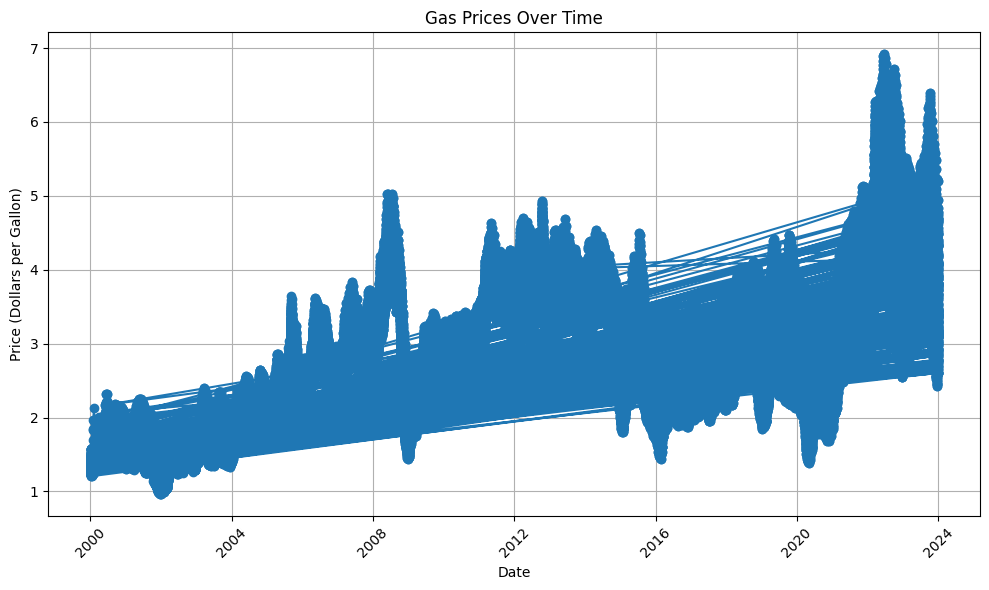

In [39]:
week_gas['Date'] = pd.to_datetime(week_gas['Date'])

# Check for null values in the 'Price' column
null_price_rows = week_gas['Price'].isnull()

# Filter out rows with null values in the 'Price' column
gas_prices = week_gas[~null_price_rows]

# Plot the cost of gas over time
plt.figure(figsize=(10, 6))
plt.plot(gas_prices['Date'], gas_prices['Price'], marker='o', linestyle='-')
plt.title('Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (Dollars per Gallon)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
print(month_transport.columns)


Index(['Date', 'Month', 'Year', 'Air Safety - General Aviation Fatalities',
       'Highway Fatalities Per 100 Million Vehicle Miles Traveled',
       'Highway Fatalities',
       'U.S. Airline Traffic - Total - Seasonally Adjusted',
       'U.S. Airline Traffic - International - Seasonally Adjusted',
       'U.S. Airline Traffic - Domestic - Seasonally Adjusted',
       'Transit Ridership - Other Transit Modes - Adjusted',
       ...
       'Heavy truck sales SAAR (millions)',
       'U.S. Airline Traffic - Total - Non Seasonally Adjusted',
       'Light truck sales SAAR (millions)',
       'U.S. Airline Traffic - International - Non Seasonally Adjusted',
       'Auto sales SAAR (millions)',
       'U.S. Airline Traffic - Domestic - Non Seasonally Adjusted',
       'Transborder - Total North American Freight',
       'Transborder - U.S. - Mexico Freight',
       'U.S. marketing air carriers on-time performance (percent)',
       'Transborder - U.S. - Canada Freight'],
      dtype='obj

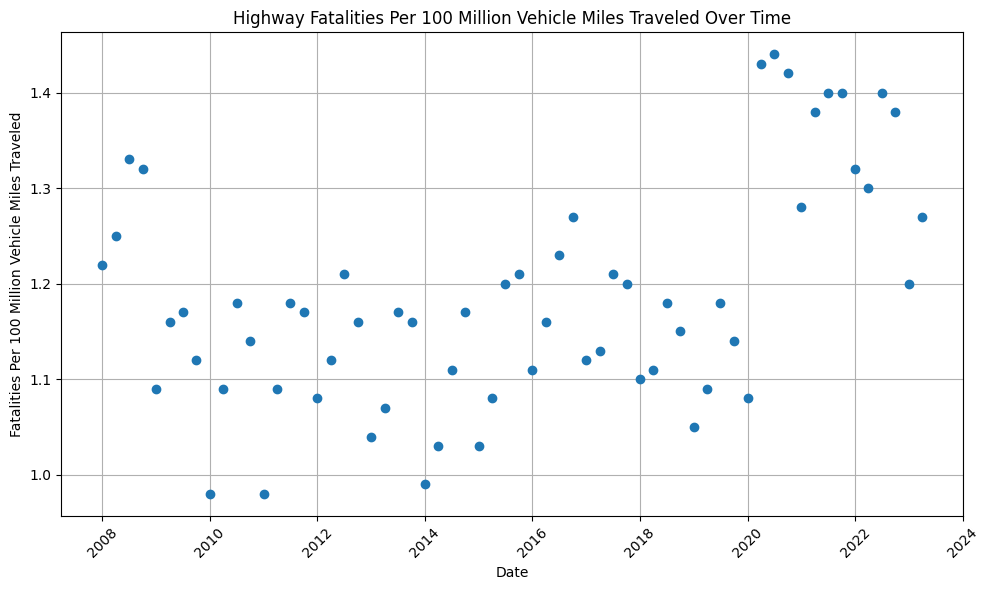

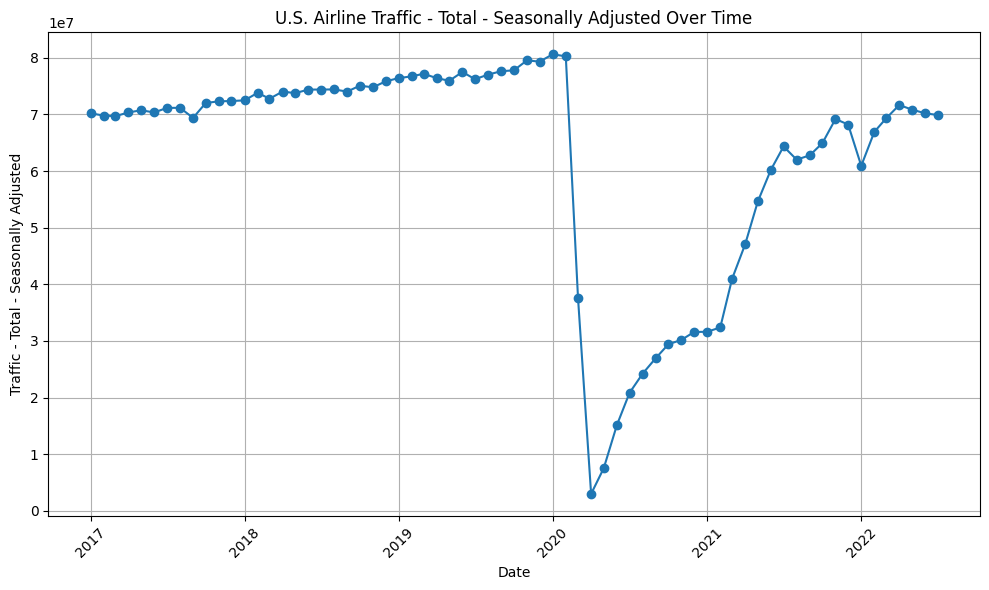

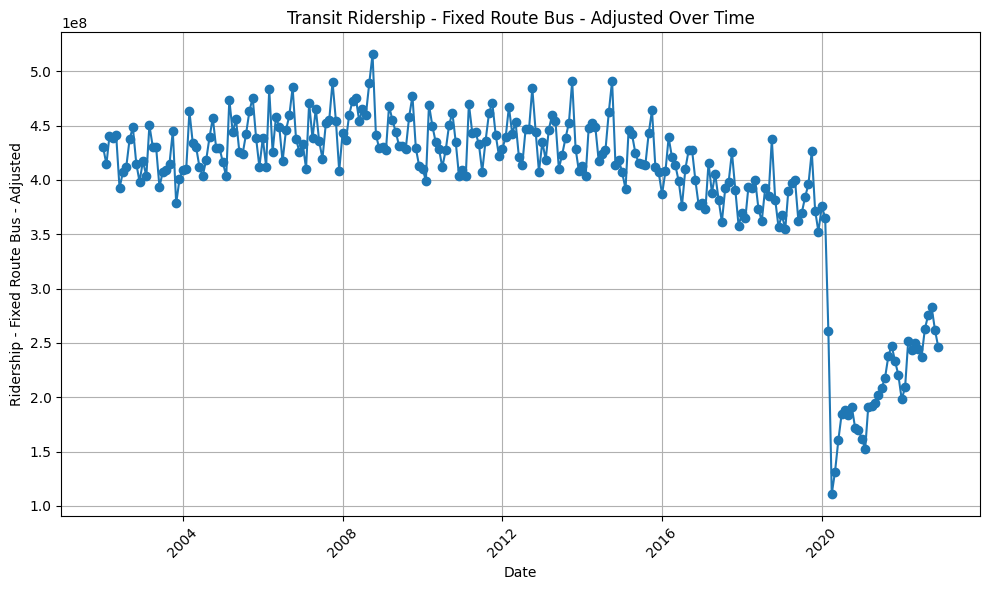

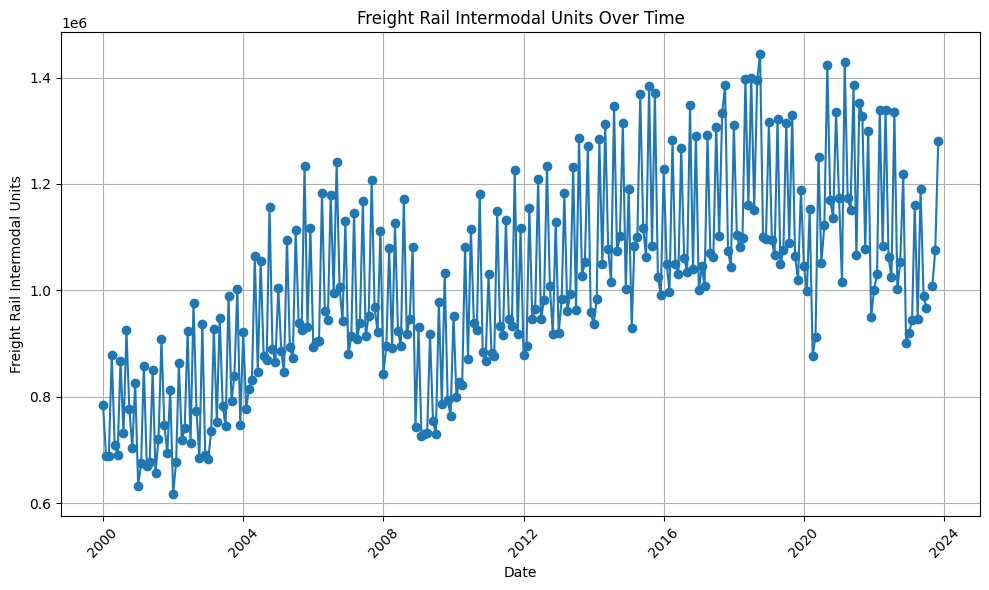

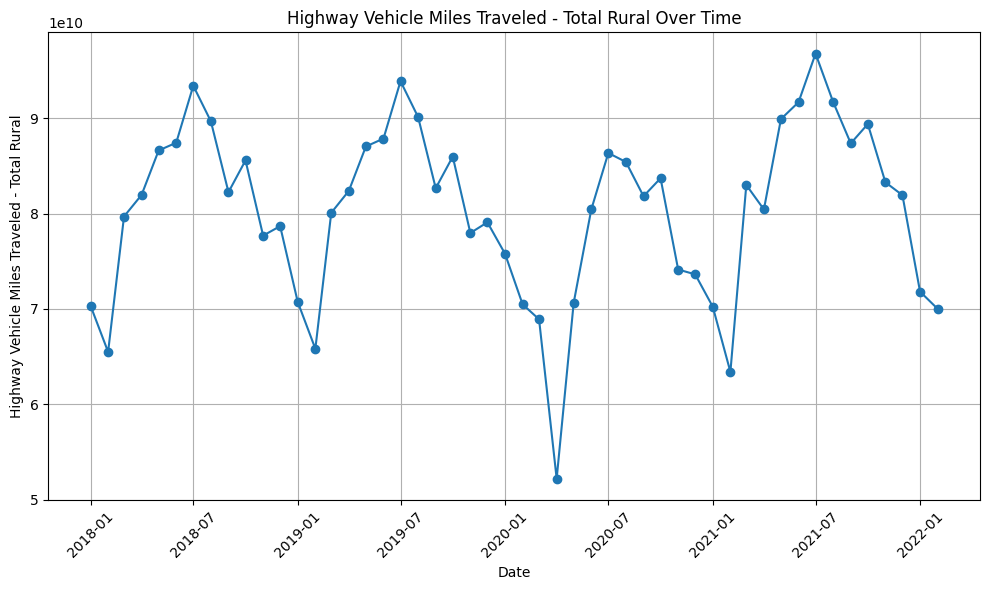

In [47]:
month_transport['Date'] = pd.to_datetime(month_transport['Date'])

# Make a copy of the DataFrame
month_transport_copy = month_transport.copy()

# Drop rows with too many NaN values
threshold = len(month_transport_copy) * 0.9  # Define a threshold for NaN values
# month_transport_cleaned = month_transport_copy.dropna(thresh=threshold, axis=1)

# Plotting the trend of 'Highway Fatalities Per 100 Million Vehicle Miles Traveled' over time
plt.figure(figsize=(10, 6))
plt.plot(month_transport_copy['Date'], month_transport_copy['Highway Fatalities Per 100 Million Vehicle Miles Traveled'], marker='o')
plt.title('Highway Fatalities Per 100 Million Vehicle Miles Traveled Over Time')
plt.xlabel('Date')
plt.ylabel('Fatalities Per 100 Million Vehicle Miles Traveled')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizing the trend of 'U.S. Airline Traffic - Total - Seasonally Adjusted' over time
plt.figure(figsize=(10, 6))
plt.plot(month_transport_copy['Date'], month_transport_copy['U.S. Airline Traffic - Total - Seasonally Adjusted'], marker='o')
plt.title('U.S. Airline Traffic - Total - Seasonally Adjusted Over Time')
plt.xlabel('Date')
plt.ylabel('Traffic - Total - Seasonally Adjusted')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the trend of 'Transit Ridership - Fixed Route Bus - Adjusted' over time
plt.figure(figsize=(10, 6))
plt.plot(month_transport_copy['Date'], month_transport_copy['Transit Ridership - Fixed Route Bus - Adjusted'], marker='o')
plt.title('Transit Ridership - Fixed Route Bus - Adjusted Over Time')
plt.xlabel('Date')
plt.ylabel('Ridership - Fixed Route Bus - Adjusted')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizing the trend of 'Freight Rail Intermodal Units' over time
plt.figure(figsize=(10, 6))
plt.plot(month_transport_copy['Date'], month_transport_copy['Freight Rail Intermodal Units'], marker='o')
plt.title('Freight Rail Intermodal Units Over Time')
plt.xlabel('Date')
plt.ylabel('Freight Rail Intermodal Units')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the trend of 'Highway Vehicle Miles Traveled - Total Rural' over time
plt.figure(figsize=(10, 6))
plt.plot(month_transport_copy['Date'], month_transport_copy['Highway Vehicle Miles Traveled - Total Rural'], marker='o')
plt.title('Highway Vehicle Miles Traveled - Total Rural Over Time')
plt.xlabel('Date')
plt.ylabel('Highway Vehicle Miles Traveled - Total Rural')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Yearly Variation in the Number of Flights
yearly_flights = departure_data.groupby('Year')['Total'].sum()

plt.figure(figsize=(10, 6))
plt.scatter(yearly_flights.index, yearly_flights.values, color='skyblue', label='Yearly Flights', marker='o')

# Make line plot
plt.plot(yearly_flights.index, yearly_flights.values, color='orange', linestyle='-', marker='', label='Trend Line')

plt.xlabel('Year')
plt.ylabel('Total Number of Flights')
plt.title('Yearly Variation in the Number of Flights')
plt.xticks(yearly_flights.index, rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
yearly_passengers = passengers_data.groupby('Year')['Total'].sum()

# Percent change from the previous year
percent_change = yearly_passengers.pct_change() * 100

plt.figure(figsize=(10, 6))
plt.bar(percent_change.index, percent_change.values, color='skyblue')
plt.xticks(percent_change.index, rotation=45, ha='right')

plt.xlabel('Year')
plt.ylabel('Percent Change')
plt.title('Percent Change of Passengers per Year')
plt.xticks(percent_change.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
yearly_departures = departure_data.groupby('Year')['Total'].sum()

# Group the passengers data by year, calculate the total number of passengers for each year
yearly_passengers = passengers_data.groupby('Year')['Total'].sum()

# Create a scatter plot to visualize the correlation between departures and passengers
plt.figure(figsize=(10, 6))
plt.scatter(yearly_departures, yearly_passengers, color='skyblue', alpha=0.7)
plt.xlabel('Total Departures')
plt.ylabel('Total Passengers')
plt.title('Correlation between Departures and Passengers')
plt.grid()

correlation_coefficient = yearly_departures.corr(yearly_passengers)

# Display correlation coefficient
plt.text(300000, 3e7, f'Correlation Coefficient: {correlation_coefficient:.2f}', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Sort the data by passenger traffic and select the top 20 busiest airports
top_20_airports = airport_passengers.sort_values(by='Total', ascending=False).head(20)

print(top_20_airports)

# Create a map
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add markers to the map
for index, row in top_20_airports.iterrows():
    usg_apt = row['usg_apt']
    airport_info = airport_data[airport_data['AIRPORT'] == usg_apt]

    if not airport_info.empty:
        airport_info = airport_info.iloc[0]
        airport_name = airport_info['DISPLAY_AIRPORT_NAME']
        latitude = airport_info['LAT_DEGREES']
        longitude = airport_info['LONGITUDE']
        if not pd.isna(latitude) and not pd.isna(longitude):
            folium.Marker([latitude, longitude], tooltip=airport_name).add_to(m)

m.save('top_20_airports_map.html')
m

KeyError: 'date'

<Figure size 1600x1000 with 0 Axes>

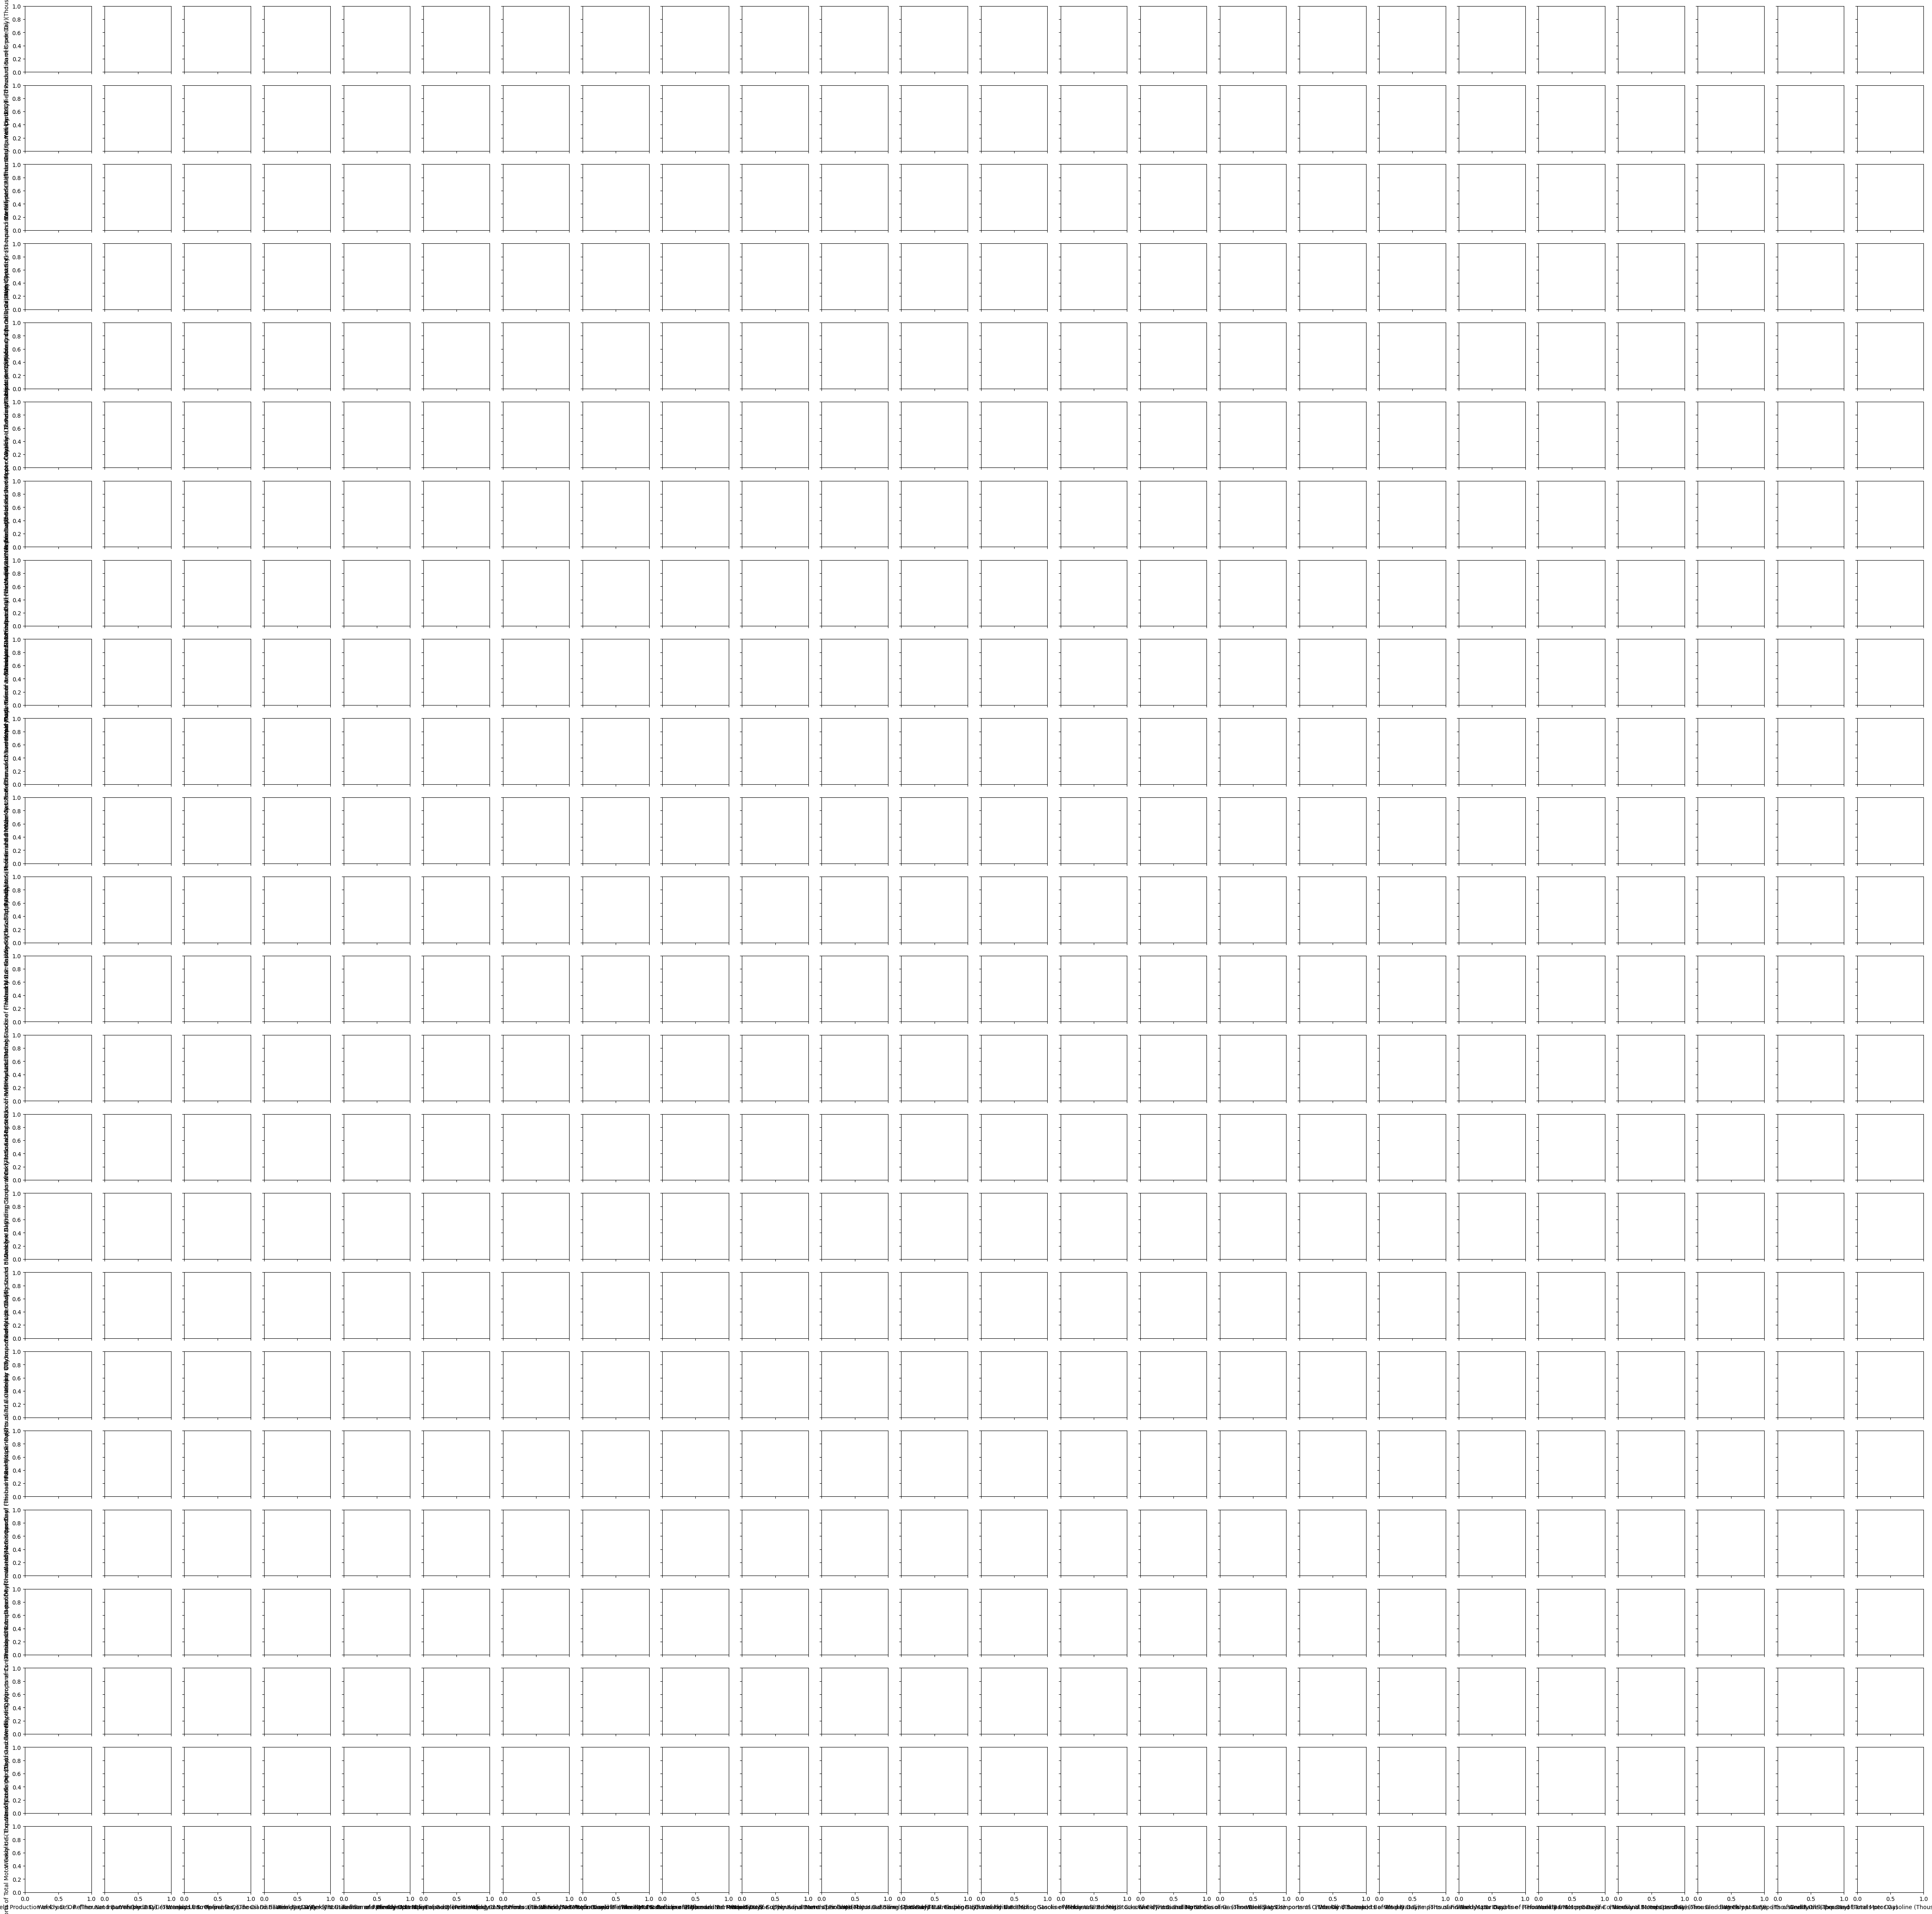

In [49]:
# Plotting graphs representing female vs male results in each category

plt.figure(1, figsize=(16,10))
sns.pairplot(data=week_supply, hue='date')
plt.show()